#### library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from layers.transformer_encdec import Encoder, EncoderLayer
from layers.selfattention_family import FullAttention, AttentionLayer
from layers.embed import PatchEmbedding, DataEmbedding_wo_pos
from layers.autoformer_encdec import series_decomp, series_decomp_multi
from layers.autoformer_encdec import series_decomp_fixed, series_decomp_fixed_multi
from layers.standard import Normalize

print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

2.4.1+cu121
Device: cuda


#### data load

In [2]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [3]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:03<00:00, 30.23it/s]


In [4]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [5]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

In [6]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [7]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]

# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [8]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [9]:
def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

In [13]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

Mean Squared Error on Validation Set: 0.0006475219728316957


In [14]:
df = pd.concat([std_train_df, std_test_df], ignore_index=True)
df.head()

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_fees-transaction_fees_transaction_mean,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,0.242277,-0.739005,-0.790786,0.677313,-0.660030,0.248331,-0.452496,...,-0.327741,-0.346728,-0.099874,0.946969,-0.472265,-0.467622,-0.289134,-0.23536,-0.2937,-0.232519
1,2023-01-01 01:00:00,1.0,train,0.242277,-0.555248,-0.812900,2.230195,-2.214769,2.351257,-0.476448,...,-0.328215,-0.319897,0.005954,-0.773384,-0.540988,-0.496686,-0.289134,-0.23536,-0.2937,-0.232519
2,2023-01-01 02:00:00,1.0,train,0.242277,-0.844533,-0.783052,-1.185413,1.204924,-0.646820,-0.417162,...,-0.328215,-0.346728,-0.005201,-0.889786,-0.528197,-0.491262,-0.289134,-0.23536,-0.2937,-0.232519
3,2023-01-01 03:00:00,1.0,train,0.242277,-0.809874,-0.841254,0.671624,-0.654333,0.244119,-0.486115,...,-0.304814,-0.346728,-0.036679,-0.447158,-0.549200,-0.500178,-0.289134,-0.23536,-0.2937,-0.232519
4,2023-01-01 04:00:00,2.0,train,0.242277,-0.701877,-0.660023,-0.369732,0.388268,-0.346476,-0.449115,...,-0.313955,-0.346728,-0.036056,0.343477,-0.521007,-0.488245,-0.289134,-0.23536,-0.2937,-0.232519


In [15]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 20)

In [16]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
    close_diff = df['close'].diff().fillna(0),
    close_diffg = np.sign(df['close'].diff().fillna(0))
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg", "close_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
    "close_diff"
]

In [17]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [18]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

#### patchTST training

##### data split & loader

In [17]:
# final data
print(train_df.shape, test_df.shape)

# train data split for training
train_data = train_df.iloc[:,2:]
valid_data = train_df["target"]

x_train, x_valid, y_train, y_valid = train_test_split(train_data, valid_data, test_size=0.2, random_state=42, shuffle=False)

# 3. 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.long)

# 4. 데이터셋과 DataLoader 준비
# seq_len 설정
seq_len = 24
batch_size = 128

# 5. 시계열 데이터에 맞게 3차원 텐서로 변환
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        label = y[i + seq_len]  # 다음 시간 스텝의 레이블
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.tensor(labels)

train_X_seq, train_y_seq = create_sequences(train_X_tensor, train_y_tensor, seq_len)
valid_X_seq, valid_y_seq = create_sequences(valid_X_tensor, valid_y_tensor, seq_len)

# DataLoader 설정
train_dataset = TensorDataset(train_X_seq, train_y_seq)
valid_dataset = TensorDataset(valid_X_seq, valid_y_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [18]:
next(iter(train_loader))[0].shape

torch.Size([128, 24, 532])

##### model

In [19]:
class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class Model(nn.Module):
    def __init__(self, configs, patch_len=24, stride=12):
        """
        patch_len: int, patch len for patch_embedding
        stride: int, stride for patch_embedding
        """
        super().__init__()
        self.task_name = configs['task_name']
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']
        padding = stride

        # patching and embedding
        self.patch_embedding = PatchEmbedding(
            configs['d_model'], patch_len, stride, padding, configs['dropout'])

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs['factor'], attention_dropout=configs['dropout'],
                                      output_attention=configs['output_attention']), configs['d_model'], configs['n_heads']),
                    configs['d_model'],
                    configs['d_ff'],
                    dropout=configs['dropout'],
                    activation=configs['activation']
                ) for l in range(configs['e_layers'])
            ],
            norm_layer=nn.Sequential(Transpose(1,2), nn.BatchNorm1d(configs['d_model']), Transpose(1,2))
        )

        # Prediction Head
        self.head_nf = configs['d_model'] * \
                       int((configs['seq_len'] - patch_len) / stride + 2)
        if self.task_name == 'classification':
            self.flatten = nn.Flatten(start_dim=-2)
            self.dropout = nn.Dropout(configs['dropout'])
            self.projection = nn.Linear(
                self.head_nf * configs['enc_in'], configs['num_class'])

    def classification(self, x_enc):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(
            torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1)
        # u: [bs * nvars x patch_num x d_model]
        enc_out, n_vars = self.patch_embedding(x_enc)

        # Encoder
        # z: [bs * nvars x patch_num x d_model]
        enc_out, attns = self.encoder(enc_out)
        # z: [bs x nvars x patch_num x d_model]
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        # Decoder
        output = self.flatten(enc_out)
        output = self.dropout(output)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        return output

    def forward(self, x_enc, mask=None):
        if self.task_name == 'classification':
            dec_out = self.classification(x_enc)
            return dec_out  # [B, N]
        return None

##### training

In [20]:
configs = {
    'task_name': 'classification',
    'seq_len': 24,  # Total features
    'pred_len': 24,  # Prediction length
    'd_model': 128,  # Embedding dimension
    'dropout': 0.1,
    'factor': 5,
    'output_attention': False,
    'n_heads': 4,  # Number of heads in the Transformer
    'e_layers': 3,  # Number of encoder layers
    'd_ff': 256,  # Dimension of feed-forward layers
    'enc_in': 532,  # Input size
    'num_class': 4,  # Number of classes
    'activation': 'relu'
}

model = Model(configs, patch_len=24, stride=12).to('cuda')

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 50
patience = 5  # Improvement 없을 때 기다릴 에포크 수
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Adjusted based on the model's input
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

    # Validation step
    model.eval()
    y_pred = []
    y_true = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Validation loss 계산
            val_loss += loss.item()

            # Prediction and accuracy calculation
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    val_loss = val_loss / len(valid_loader)
    accuracy = accuracy_score(y_true, y_pred)

    if epoch % 10 == 0:
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}')

Epoch [1/50], Loss: 3.7949223041534426
Validation Accuracy: 43.11%
Validation Loss: 1.7809
Epoch [11/50], Loss: 1.1881092104044828
Validation Accuracy: 39.41%
Validation Loss: 2.7812
Epoch [21/50], Loss: 1.0780133962631226
Validation Accuracy: 9.43%
Validation Loss: 2.4129
Epoch [31/50], Loss: 1.0058964317495174
Validation Accuracy: 31.60%
Validation Loss: 1.5497
Epoch [41/50], Loss: 0.9773329442197626
Validation Accuracy: 37.67%
Validation Loss: 1.4211


In [38]:
test_data = pd.concat([train_df.iloc[-24:,2:], test_df.iloc[:,2:]], axis=0)
test_data.shape

(2816, 532)

In [39]:
# 시퀀스 길이 및 특징 개수 정의
seq_len = 24
feature_n = 532

# 슬라이딩 윈도우로 데이터 준비
def create_sequences(X, seq_len):
    sequences = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        sequences.append(seq)
    return torch.stack(sequences)

# test_X_tensor: (2792, 532)
test_X_tensor = torch.tensor(test_data.values, dtype=torch.float32)

# 2. seq_len을 24로 설정하고, 시계열 데이터에 맞게 변환
seq_len = 24
test_X_seq = create_sequences(test_X_tensor, seq_len)

# 3. DataLoader 생성 (배치 사이즈는 자유롭게 설정 가능, 여기서는 128)
test_dataset = TensorDataset(test_X_seq)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [40]:
# 모델 예측 수행
model.eval()
test_predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to('cuda')  # 입력 데이터만 필요
        outputs = model(inputs, None)  # 모델의 예측 결과
        _, predicted = torch.max(outputs, 1)  # 예측 클래스 선택
        test_predictions.extend(predicted.cpu().numpy())  # 결과를 리스트에 추가

In [43]:
# output file 할당후 save 
submission_df = submission_df.assign(target = test_predictions)
submission_df.to_csv("output/output_patchTST.csv", index=False)

#### forecast

In [18]:
class Transpose(nn.Module):
    def __init__(self, *dims, contiguous=False): 
        super().__init__()
        self.dims, self.contiguous = dims, contiguous
    def forward(self, x):
        if self.contiguous: return x.transpose(*self.dims).contiguous()
        else: return x.transpose(*self.dims)


class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):  # x: [bs x nvars x d_model x patch_num]
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x


class Model(nn.Module):
    def __init__(self, configs, patch_len=16, stride=8):
        super().__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']
        padding = stride

        # patching and embedding
        self.patch_embedding = PatchEmbedding(
            configs['d_model'], patch_len, stride, padding, configs['dropout'])

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, configs['factor'], attention_dropout=configs['dropout'],
                                      output_attention=configs['output_attention']), configs['d_model'], configs['n_heads']),
                    configs['d_model'],
                    configs['d_ff'],
                    dropout=configs['dropout'],
                    activation=configs['activation']
                ) for l in range(configs['e_layers'])
            ],
            norm_layer=nn.Sequential(Transpose(1,2), nn.BatchNorm1d(configs['d_model']), Transpose(1,2))
        )

        # Prediction Head
        self.head_nf = configs['d_model'] * \
                       int((configs['seq_len'] - patch_len) / stride + 2)
        self.head = FlattenHead(configs['enc_in'], self.head_nf, configs['pred_len'],
                                    head_dropout=configs['dropout'])

    def forecast(self, x_enc):
        # Normalization from Non-stationary Transformer
        means = x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - means
        stdev = torch.sqrt(
            torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= stdev

        # do patching and embedding
        x_enc = x_enc.permute(0, 2, 1)
        # u: [bs * nvars x patch_num x d_model]
        enc_out, n_vars = self.patch_embedding(x_enc)

        # Encoder
        # z: [bs * nvars x patch_num x d_model]
        enc_out, attns = self.encoder(enc_out)
        # z: [bs x nvars x patch_num x d_model]
        enc_out = torch.reshape(
            enc_out, (-1, n_vars, enc_out.shape[-2], enc_out.shape[-1]))
        # z: [bs x nvars x d_model x patch_num]
        enc_out = enc_out.permute(0, 1, 3, 2)

        # Decoder
        dec_out = self.head(enc_out)  # z: [bs x nvars x target_window]
        dec_out = dec_out.permute(0, 2, 1)

        # De-Normalization from Non-stationary Transformer
        dec_out = dec_out * \
                  (stdev[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + \
                  (means[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out

    def forward(self, x_enc):
        dec_out = self.forecast(x_enc)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [96]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

# 3. 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.long)

# 4. 데이터셋과 DataLoader 준비
# seq_len 설정
seq_len = 24
batch_size = 128

# 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.float32)  # Change dtype to float32 for regression
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.float32)  # Change dtype to float32 for regression

# 시계열 데이터에 맞게 3차원 텐서로 변환
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        label = y[i + seq_len]  # 다음 시간 스텝의 레이블
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.stack(labels)

train_X_seq, train_y_seq = create_sequences(train_X_tensor, train_y_tensor, seq_len)
valid_X_seq, valid_y_seq = create_sequences(valid_X_tensor, valid_y_tensor, seq_len)

# DataLoader 설정
train_dataset = TensorDataset(train_X_seq, train_y_seq)
valid_dataset = TensorDataset(valid_X_seq, valid_y_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [103]:
configs = {
    'seq_len': 24,        # 입력 시퀀스 길이
    'pred_len': 1,        # 예측할 길이 (가격 예측이므로 1)
    'enc_in': 205,        # 입력 피처 수
    'd_model': 64,        # 모델 차원
    'e_layers': 3,        # 인코더 레이어 수
    'd_ff': 128,          # 피드 포워드 네트워크 차원
    'n_heads': 4,         # 어텐션 헤드 수
    'factor': 5,          # 어텐션 팩터 (적절히 설정)
    'dropout': 0.1,       # 드롭아웃 비율
    'activation': 'relu',  # 활성화 함수
    'output_attention': False # 어텐션 출력 여부
}

model = Model(configs, patch_len=24, stride=12).to(device)

In [104]:
for batch_idx, (x_enc, y) in enumerate(train_loader):
    print(batch_idx)
    print(x_enc.shape)
    print(y.shape)

    optimizer.zero_grad()
    outputs = model(x_enc.to(device))

    a = outputs
    b = y.to(device).unsqueeze(1)
    print(a.shape)
    print(b.shape)
    
    if batch_idx > 1:
        break

0
torch.Size([128, 24, 205])
torch.Size([128])
torch.Size([128, 1, 205])
torch.Size([128, 1])
1
torch.Size([128, 24, 205])
torch.Size([128])
torch.Size([128, 1, 205])
torch.Size([128, 1])
2
torch.Size([128, 24, 205])
torch.Size([128])
torch.Size([128, 1, 205])
torch.Size([128, 1])


In [108]:
# Training Loop
num_epochs = 5  # Set number of epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0

    for batch_idx, (x_enc, y) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero gradients
        
        # Forward pass
        outputs = model(x_enc.to(device))  # Model's prediction
        
        # Compute loss
        loss = criterion(outputs[:, -1, :], y.to(device).unsqueeze(1))  # Compare the last prediction with target
        total_train_loss += loss.item()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    total_valid_loss = 0

    with torch.no_grad():  # No need to compute gradients during validation
        for batch_idx, (x_enc, y) in enumerate(valid_loader):
            outputs = model(x_enc.to(device))  # Model's prediction
            loss = criterion(outputs[:, -1, :], y.to(device).unsqueeze(1))  # Compare the last prediction with target
            total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(valid_loader)

    # Print epoch statistics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_valid_loss:.4f}')

Epoch [1/5], Train Loss: 0.8269, Validation Loss: 3.0366
Epoch [2/5], Train Loss: 0.8243, Validation Loss: 3.0350
Epoch [3/5], Train Loss: 0.8312, Validation Loss: 3.0363
Epoch [4/5], Train Loss: 0.8262, Validation Loss: 3.0355
Epoch [5/5], Train Loss: 0.8274, Validation Loss: 3.0352


In [106]:
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

test_X_tensor = torch.tensor(X_test.values, dtype=torch.float32)

def create_sequences(X, seq_len):
    sequences = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        sequences.append(seq)
    return torch.stack(sequences)

test_X_seq = create_sequences(test_X_tensor, seq_len)

test_dataset = TensorDataset(test_X_seq)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():  # No need to compute gradients during testing
    for x_enc in test_loader:
        x_enc = x_enc[0]  # Get the sequence tensor from the DataLoader
        if torch.cuda.is_available():  # Check if CUDA is available
            x_enc = x_enc.cuda()  # Move to GPU if available
        output = model(x_enc)  # Get model predictions
        predictions.append(outputs[:, -1, :])  # Append the entire output

len(predictions)

22

In [84]:
predictions.numpy()

AttributeError: 'list' object has no attribute 'numpy'

In [ ]:

# Concatenate the predictions into a single tensor
predictions_tensor = torch.cat(predictions, dim=0)

# Move predictions to CPU before converting to numpy
predictions_array = predictions_tensor.cpu().numpy()

# Check the shape of predictions
print(predictions_array.shape)  # This should match [N, D] where N is the number of predictions

# If you only want the last time step of predictions, you can use:
final_predictions = predictions_array.squeeze(axis=1)  # Get the last time step's predictions

# Output the final predictions
print(final_predictions)

In [69]:
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
y_train

0      -2.083215
1      -2.079750
2      -2.081277
3      -2.083744
4      -2.085260
          ...   
8755    2.344851
8756    2.334293
8757    2.327828
8758    2.286965
8759    2.291854
Name: hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close, Length: 8760, dtype: float64

In [73]:
final_df = pd.DataFrame(final_predictions)
final_df

,0
0,0.899141
1,-0.021093
2,-0.031150
3,0.049061
4,0.287036
...,...
567435,1.047306
567436,-0.107387
567437,-0.214363
567438,0.118492


ValueError: x and y must have same first dimension, but have shapes (567439,) and (567440,)

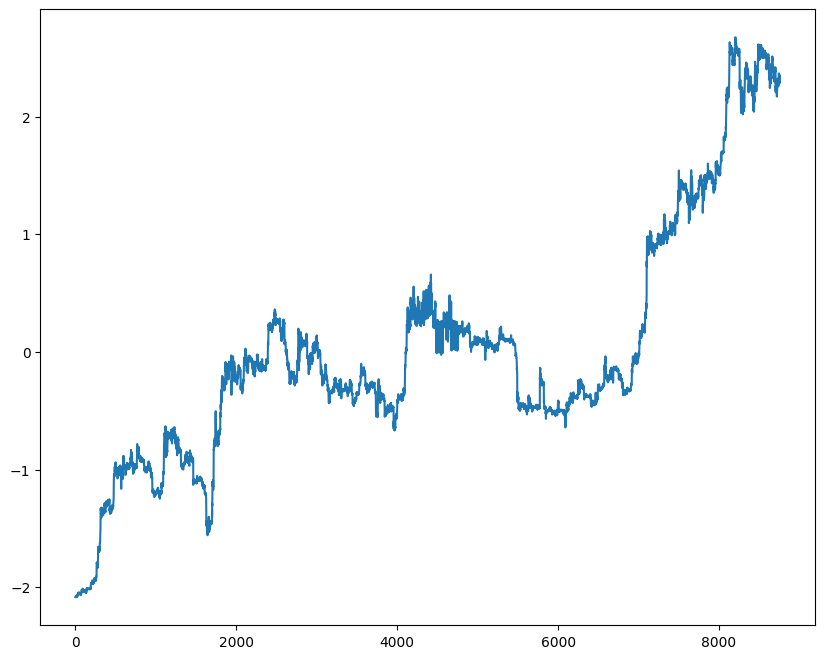

In [71]:
plt.figure(figsize=(10,8))
plt.plot(y_train.index, y_train.values)
plt.plot(range(y_train.shape[0]+1, y_train.shape[0]+len(final_predictions)), final_predictions, c = 'r')
plt.show()

#### Dlinear model

In [44]:
class Model(nn.Module):

    def __init__(self, configs, individual=False):
        super(Model, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['seq_len']
        # Series decomposition block from Autoformer
        self.decompsition = series_decomp(configs['moving_avg'])
        self.individual = individual
        self.channels = configs['enc_in']

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(
                    nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(
                    nn.Linear(self.seq_len, self.pred_len))

                self.Linear_Seasonal[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            self.Linear_Seasonal.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))

        self.projection = nn.Linear(
            configs['enc_in'] * configs['seq_len'], configs['num_class'])

    def encoder(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(
            0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                                          dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len],
                                       dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](
                    seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](
                    trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

    def classification(self, x_enc):
        # Encoder
        enc_out = self.encoder(x_enc)
        # Output
        # (batch_size, seq_length * d_model)
        output = enc_out.reshape(enc_out.shape[0], -1)
        # (batch_size, num_classes)
        output = self.projection(output)
        return output

    def forward(self, x_enc, mask=None):
        dec_out = self.classification(x_enc)
        return dec_out  # [B, N]

In [45]:
# train data split for training
train_data = train_df.iloc[:,2:]
valid_data = train_df["target"]

x_train, x_valid, y_train, y_valid = train_test_split(train_data, valid_data, test_size=0.2, random_state=42, shuffle=False)

# 3. 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.long)

# 4. 데이터셋과 DataLoader 준비
# seq_len 설정
seq_len = 24
batch_size = 64

# 5. 시계열 데이터에 맞게 3차원 텐서로 변환
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        label = y[i + seq_len]  # 다음 시간 스텝의 레이블
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.tensor(labels)

train_X_seq, train_y_seq = create_sequences(train_X_tensor, train_y_tensor, seq_len)
valid_X_seq, valid_y_seq = create_sequences(valid_X_tensor, valid_y_tensor, seq_len)

# DataLoader 설정
train_dataset = TensorDataset(train_X_seq, train_y_seq)
valid_dataset = TensorDataset(valid_X_seq, valid_y_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [53]:
# 7. 모델 학습 및 검증
configs = {
    'seq_len': seq_len,
    'moving_avg': 12, 
    'enc_in': x_train.shape[1],  # 입력 특성의 수
    'num_class': 4  # 클래스 수
}

# 모델 생성
model = Model(configs=configs, individual=False).to('cuda')

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Training loop
num_epochs = 100
patience = 5  # Improvement 없을 때 기다릴 에포크 수
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)  # Adjusted based on the model's input
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}')

    # Validation step
    model.eval()
    y_pred = []
    y_true = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Validation loss 계산
            val_loss += loss.item()

            # Prediction and accuracy calculation
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    val_loss = val_loss / len(valid_loader)
    accuracy = accuracy_score(y_true, y_pred)

    if epoch % 10 == 0:
        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}')

RuntimeError: The size of tensor a (24) must match the size of tensor b (23) at non-singleton dimension 1

#### SegRNN

In [20]:
class Model(nn.Module):

    def __init__(self, configs):
        super(Model, self).__init__()

        # get parameters
        self.seq_len = configs['seq_len']
        self.enc_in = configs['enc_in']
        self.d_model = configs['d_model']
        self.dropout = configs['dropout']

        self.pred_len = configs['seq_len']

        self.seg_len = configs['seg_len']
        self.seg_num_x = self.seq_len // self.seg_len
        self.seg_num_y = self.pred_len // self.seg_len

        # building model
        self.valueEmbedding = nn.Sequential(
            nn.Linear(self.seg_len, self.d_model),
            nn.ReLU()
        )
        self.rnn = nn.GRU(input_size=self.d_model, hidden_size=self.d_model, num_layers=1, bias=True,
                              batch_first=True, bidirectional=False)
        self.pos_emb = nn.Parameter(torch.randn(self.seg_num_y, self.d_model // 2))
        self.channel_emb = nn.Parameter(torch.randn(self.enc_in, self.d_model // 2))

        self.predict = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(self.d_model, self.seg_len)
        )

        self.act = F.gelu
        self.dropout = nn.Dropout(configs['dropout'])
        self.projection = nn.Linear(
            configs['enc_in'] * configs['seq_len'], configs['num_class'])

    def encoder(self, x):
        # b:batch_size c:channel_size s:seq_len s:seq_len
        # d:d_model w:seg_len n:seg_num_x m:seg_num_y
        batch_size = x.size(0)
        seq_last = x[:, -1:, :].detach()
        x = (x - seq_last).permute(0, 2, 1) # b,c,s

        x = self.valueEmbedding(x.reshape(-1, self.seg_num_x, self.seg_len))

        # encoding
        _, hn = self.rnn(x) # bc,n,d  1,bc,d

        # m,d//2 -> 1,m,d//2 -> c,m,d//2
        # c,d//2 -> c,1,d//2 -> c,m,d//2
        # c,m,d -> cm,1,d -> bcm, 1, d
        pos_emb = torch.cat([
            self.pos_emb.unsqueeze(0).repeat(self.enc_in, 1, 1),
            self.channel_emb.unsqueeze(1).repeat(1, self.seg_num_y, 1)
        ], dim=-1).view(-1, 1, self.d_model).repeat(batch_size,1,1)

        _, hy = self.rnn(pos_emb, hn.repeat(1, 1, self.seg_num_y).view(1, -1, self.d_model)) # bcm,1,d  1,bcm,d

        # 1,bcm,d -> 1,bcm,w -> b,c,s
        y = self.predict(hy).view(-1, self.enc_in, self.pred_len)

        # permute and denorm
        y = y.permute(0, 2, 1) + seq_last
        return y

    def classification(self, x_enc):
        # Encoder
        enc_out = self.encoder(x_enc)
        # Output
        # (batch_size, seq_length * d_model)
        output = enc_out.reshape(enc_out.shape[0], -1)
        # (batch_size, num_classes)
        output = self.projection(output)
        return output

    def forward(self, x_enc):
        dec_out = self.classification(x_enc)
        return dec_out  # [B, N]

In [21]:
# train data split for training
train_data = train_df.iloc[:,2:]
valid_data = train_df["target"]

x_train, x_valid, y_train, y_valid = train_test_split(train_data, valid_data, test_size=0.2, random_state=42, shuffle=False)

# 3. 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.long)

# 4. 데이터셋과 DataLoader 준비
# seq_len 설정
seq_len = 24
batch_size = 128

# 5. 시계열 데이터에 맞게 3차원 텐서로 변환
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        label = y[i + seq_len]  # 다음 시간 스텝의 레이블
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.tensor(labels)

train_X_seq, train_y_seq = create_sequences(train_X_tensor, train_y_tensor, seq_len)
valid_X_seq, valid_y_seq = create_sequences(valid_X_tensor, valid_y_tensor, seq_len)

# DataLoader 설정
train_dataset = TensorDataset(train_X_seq, train_y_seq)
valid_dataset = TensorDataset(valid_X_seq, valid_y_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [22]:
next(iter(train_loader))[0].shape

torch.Size([128, 24, 532])

In [23]:
# Parameters
configs = {
    'seq_len': 24,    # For example, define your sequence length
    'enc_in': 532,    # Input feature dimension
    'd_model': 128,    # Model dimension
    'dropout': 0.1,   # Dropout rate
    'seg_len': 6,     # Define segment length
    'num_class': 4    # Number of classes for classification
}

In [24]:
# Initialize model
model = Model(configs)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [25]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

# Evaluation function
def evaluate(model, valid_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10  # Number of epochs to train
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)
    accuracy = evaluate(model, valid_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')


Epoch [1/10], Test Accuracy: 40.05%
Epoch [2/10], Test Accuracy: 38.54%
Epoch [3/10], Test Accuracy: 26.04%
Epoch [4/10], Test Accuracy: 28.59%
Epoch [5/10], Test Accuracy: 40.51%
Epoch [6/10], Test Accuracy: 11.34%
Epoch [7/10], Test Accuracy: 21.30%
Epoch [8/10], Test Accuracy: 11.81%
Epoch [9/10], Test Accuracy: 11.11%
Epoch [10/10], Test Accuracy: 13.14%


#### Timemixer

In [71]:
class DFT_series_decomp(nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, top_k=5):
        super(DFT_series_decomp, self).__init__()
        self.top_k = top_k

    def forward(self, x):
        xf = torch.fft.rfft(x)
        freq = abs(xf)
        freq[0] = 0
        top_k_freq, top_list = torch.topk(freq, 5)
        xf[freq <= top_k_freq.min()] = 0
        x_season = torch.fft.irfft(xf)
        x_trend = x - x_season
        return x_season, x_trend


class MultiScaleSeasonMixing(nn.Module):
    """
    Bottom-up mixing season pattern
    """

    def __init__(self, configs):
        super(MultiScaleSeasonMixing, self).__init__()

        self.down_sampling_layers = torch.nn.ModuleList(
            [
                nn.Sequential(
                    torch.nn.Linear(
                        configs['seq_len'] // (configs['down_sampling_window'] ** i),
                        configs['seq_len'] // (configs['down_sampling_window'] ** (i + 1)),
                    ),
                    nn.GELU(),
                    torch.nn.Linear(
                        configs['seq_len'] // (configs['down_sampling_window'] ** (i + 1)),
                        configs['seq_len'] // (configs['down_sampling_window'] ** (i + 1)),
                    ),

                )
                for i in range(configs['down_sampling_layers'])
            ]
        )

    def forward(self, season_list):

        # mixing high->low
        out_high = season_list[0]
        out_low = season_list[1]
        out_season_list = [out_high.permute(0, 2, 1)]

        for i in range(len(season_list) - 1):
            out_low_res = self.down_sampling_layers[i](out_high)
            out_low = out_low + out_low_res
            out_high = out_low
            if i + 2 <= len(season_list) - 1:
                out_low = season_list[i + 2]
            out_season_list.append(out_high.permute(0, 2, 1))

        return out_season_list


class MultiScaleTrendMixing(nn.Module):
    """
    Top-down mixing trend pattern
    """

    def __init__(self, configs):
        super(MultiScaleTrendMixing, self).__init__()

        self.up_sampling_layers = torch.nn.ModuleList(
            [
                nn.Sequential(
                    torch.nn.Linear(
                        configs['seq_len'] // (configs['down_sampling_window'] ** (i + 1)),
                        configs['seq_len'] // (configs['down_sampling_window'] ** i),
                    ),
                    nn.GELU(),
                    torch.nn.Linear(
                        configs['seq_len'] // (configs['down_sampling_window'] ** i),
                        configs['seq_len'] // (configs['down_sampling_window'] ** i),
                    ),
                )
                for i in reversed(range(configs['down_sampling_layers']))
            ])

    def forward(self, trend_list):

        # mixing low->high
        trend_list_reverse = trend_list.copy()
        trend_list_reverse.reverse()
        out_low = trend_list_reverse[0]
        out_high = trend_list_reverse[1]
        out_trend_list = [out_low.permute(0, 2, 1)]

        for i in range(len(trend_list_reverse) - 1):
            out_high_res = self.up_sampling_layers[i](out_low)
            out_high = out_high + out_high_res
            out_low = out_high
            if i + 2 <= len(trend_list_reverse) - 1:
                out_high = trend_list_reverse[i + 2]
            out_trend_list.append(out_low.permute(0, 2, 1))

        out_trend_list.reverse()
        return out_trend_list


class PastDecomposableMixing(nn.Module):
    def __init__(self, configs):
        super(PastDecomposableMixing, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']
        self.down_sampling_window = configs['down_sampling_window']

        self.layer_norm = nn.LayerNorm(configs['d_model'])
        self.dropout = nn.Dropout(configs['dropout'])
        self.channel_independence = configs['channel_independence']

        if configs['decomp_method'] == 'moving_avg':
            self.decompsition = series_decomp(configs['moving_avg'])
        elif configs['decomp_method'] == "dft_decomp":
            self.decompsition = DFT_series_decomp(configs['top_k'])
        else:
            raise ValueError('decompsition is error')

        if not configs['channel_independence']:
            self.cross_layer = nn.Sequential(
                nn.Linear(in_features=configs['d_model'], out_features=configs['d_ff']),
                nn.GELU(),
                nn.Linear(in_features=configs['d_ff'], out_features=configs['d_model']),
            )

        # Mixing season
        self.mixing_multi_scale_season = MultiScaleSeasonMixing(configs)

        # Mxing trend
        self.mixing_multi_scale_trend = MultiScaleTrendMixing(configs)

        self.out_cross_layer = nn.Sequential(
            nn.Linear(in_features=configs['d_model'], out_features=configs['d_ff']),
            nn.GELU(),
            nn.Linear(in_features=configs['d_ff'], out_features=configs['d_model']),
        )

    def forward(self, x_list):
        length_list = []
        for x in x_list:
            _, T, _ = x.size()
            length_list.append(T)

        # Decompose to obtain the season and trend
        season_list = []
        trend_list = []
        for x in x_list:
            season, trend = self.decompsition(x)
            if not self.channel_independence:
                season = self.cross_layer(season)
                trend = self.cross_layer(trend)
            season_list.append(season.permute(0, 2, 1))
            trend_list.append(trend.permute(0, 2, 1))

        # bottom-up season mixing
        out_season_list = self.mixing_multi_scale_season(season_list)
        # top-down trend mixing
        out_trend_list = self.mixing_multi_scale_trend(trend_list)

        out_list = []
        for ori, out_season, out_trend, length in zip(x_list, out_season_list, out_trend_list,
                                                      length_list):
            out = out_season + out_trend
            if self.channel_independence:
                out = ori + self.out_cross_layer(out)
            out_list.append(out[:, :length, :])
        return out_list


class Model(nn.Module):

    def __init__(self, configs):
        super(Model, self).__init__()
        self.configs = configs
        self.seq_len = configs['seq_len']
        self.label_len = configs['label_len']
        self.pred_len = configs['pred_len']
        self.down_sampling_window = configs['down_sampling_window']
        self.channel_independence = configs['channel_independence']
        self.pdm_blocks = nn.ModuleList([PastDecomposableMixing(configs)
                                         for _ in range(configs['e_layers'])])

        self.preprocess = series_decomp(configs['moving_avg'])
        self.enc_in = configs['enc_in']

        if self.channel_independence:
            self.enc_embedding = DataEmbedding_wo_pos(1, configs['d_model'], configs['embed'], configs['freq'],
                                                      configs['dropout'])
        else:
            self.enc_embedding = DataEmbedding_wo_pos(configs['enc_in'], configs['d_model'], configs['embed'], configs['freq'],
                                                      configs['dropout'])

        self.layer = configs['e_layers']

        self.normalize_layers = torch.nn.ModuleList(
            [
                Normalize(self.configs['enc_in'], affine=True, non_norm=True if configs['use_norm'] == 0 else False)
                for i in range(configs['down_sampling_layers'] + 1)
            ]
        )

        self.act = F.gelu
        self.dropout = nn.Dropout(configs['dropout'])
        self.projection = nn.Linear(
            configs['d_model'] * configs['seq_len'], configs['num_class'])

    def out_projection(self, dec_out, i, out_res):
        dec_out = self.projection_layer(dec_out)
        out_res = out_res.permute(0, 2, 1)
        out_res = self.out_res_layers[i](out_res)
        out_res = self.regression_layers[i](out_res).permute(0, 2, 1)
        dec_out = dec_out + out_res
        return dec_out

    def pre_enc(self, x_list):
        if self.channel_independence:
            return (x_list, None)
        else:
            out1_list = []
            out2_list = []
            for x in x_list:
                x_1, x_2 = self.preprocess(x)
                out1_list.append(x_1)
                out2_list.append(x_2)
            return (out1_list, out2_list)

    def __multi_scale_process_inputs(self, x_enc, x_mark_enc):
        if self.configs['down_sampling_method'] == 'max':
            down_pool = torch.nn.MaxPool1d(self.configs['down_sampling_window'], return_indices=False)
        elif self.configs['down_sampling_method'] == 'avg':
            down_pool = torch.nn.AvgPool1d(self.configs['down_sampling_window'])
        elif self.configs['down_sampling_method'] == 'conv':
            padding = 1 if torch.__version__ >= '1.5.0' else 2
            down_pool = nn.Conv1d(in_channels=self.configs['enc_in'], out_channels=self.configs['enc_in'],
                                  kernel_size=3, padding=padding,
                                  stride=self.configs['down_sampling_window'],
                                  padding_mode='circular',
                                  bias=False)
        else:
            return x_enc, x_mark_enc
        # B,T,C -> B,C,T
        x_enc = x_enc.permute(0, 2, 1)

        x_enc_ori = x_enc
        x_mark_enc_mark_ori = x_mark_enc

        x_enc_sampling_list = []
        x_mark_sampling_list = []
        x_enc_sampling_list.append(x_enc.permute(0, 2, 1))
        x_mark_sampling_list.append(x_mark_enc)

        for i in range(self.configs['down_sampling_layers']):
            x_enc_sampling = down_pool(x_enc_ori)

            x_enc_sampling_list.append(x_enc_sampling.permute(0, 2, 1))
            x_enc_ori = x_enc_sampling

            if x_mark_enc is not None:
                x_mark_sampling_list.append(x_mark_enc_mark_ori[:, ::self.configs['down_sampling_window'], :])
                x_mark_enc_mark_ori = x_mark_enc_mark_ori[:, ::self.configs['down_sampling_window'], :]

        x_enc = x_enc_sampling_list
        x_mark_enc = x_mark_sampling_list if x_mark_enc is not None else None

        return x_enc, x_mark_enc


    def future_multi_mixing(self, B, enc_out_list, x_list):
        dec_out_list = []
        if self.channel_independence:
            x_list = x_list[0]
            for i, enc_out in zip(range(len(x_list)), enc_out_list):
                dec_out = self.predict_layers[i](enc_out.permute(0, 2, 1)).permute(
                    0, 2, 1)  # align temporal dimension
                dec_out = self.projection_layer(dec_out)
                dec_out = dec_out.reshape(B, self.configs.c_out, self.pred_len).permute(0, 2, 1).contiguous()
                dec_out_list.append(dec_out)

        else:
            for i, enc_out, out_res in zip(range(len(x_list[0])), enc_out_list, x_list[1]):
                dec_out = self.predict_layers[i](enc_out.permute(0, 2, 1)).permute(
                    0, 2, 1)  # align temporal dimension
                dec_out = self.out_projection(dec_out, i, out_res)
                dec_out_list.append(dec_out)

        return dec_out_list

    def classification(self, x_enc):
        x_enc, _ = self.__multi_scale_process_inputs(x_enc, None)
        x_list = x_enc

        # embedding
        enc_out_list = []
        for x in x_list:
            enc_out = self.enc_embedding(x, None)  # [B,T,C]
            enc_out_list.append(enc_out)

        # MultiScale-CrissCrossAttention  as encoder for past
        for i in range(self.layer):
            enc_out_list = self.pdm_blocks[i](enc_out_list)

        enc_out = enc_out_list[0]
        # Output
        # the output transformer encoder/decoder embeddings don't include non-linearity
        output = self.act(enc_out)
        output = self.dropout(output)
        
        # (batch_size, seq_length * d_model)
        output = output.reshape(output.shape[0], -1)
        output = self.projection(output)  # (batch_size, num_classes)
        return output


    def forward(self, x_enc):
        dec_out = self.classification(x_enc)
        return dec_out  # [B, N]

In [72]:
configs = {
        'seq_len': 24,  # 입력 시퀀스 길이
        'label_len': 1,  # 라벨 길이
        'pred_len': 1,  # 예측할 길이
        'down_sampling_window': 24,  # 다운샘플링 윈도우
        'channel_independence': True,  # 채널 독립성 여부
        'e_layers': 2,  # 인코더 레이어 수
        'moving_avg': 3,  # 이동 평균
        'enc_in': 532,  # 입력 차원
        'd_model': 64,  # 모델의 차원
        'd_ff' : 32,
        'embed': 'fixed',  # 임베딩 방법
        'decomp_method' : 'moving_avg',
        'freq': 'h',  # 데이터의 주기 (예: 시간 단위)
        'dropout': 0.1,  # 드롭아웃 비율
        'num_class': 4,  # 출력 클래스 수
        'use_norm': 1,  # 정규화 사용 여부
        'down_sampling_layers': 2,  # 다운샘플링 레이어 수
        'down_sampling_method': 'avg',  # 다운샘플링 방법 ('max', 'avg', 'conv' 중 선택)
}

In [73]:
# train data split for training
train_data = train_df.iloc[:,2:]
valid_data = train_df["target"]

x_train, x_valid, y_train, y_valid = train_test_split(train_data, valid_data, test_size=0.2, random_state=42, shuffle=False)

# 3. 데이터 텐서 변환
train_X_tensor = torch.tensor(x_train.values, dtype=torch.float32)
train_y_tensor = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
valid_X_tensor = torch.tensor(x_valid.values, dtype=torch.float32)
valid_y_tensor = torch.tensor(y_valid.values.squeeze(), dtype=torch.long)

# 4. 데이터셋과 DataLoader 준비
# seq_len 설정
seq_len = 24
batch_size = 64

# 5. 시계열 데이터에 맞게 3차원 텐서로 변환
def create_sequences(X, y, seq_len):
    sequences = []
    labels = []
    for i in range(len(X) - seq_len):
        seq = X[i:i + seq_len]
        label = y[i + seq_len]  # 다음 시간 스텝의 레이블
        sequences.append(seq)
        labels.append(label)
    return torch.stack(sequences), torch.tensor(labels)

train_X_seq, train_y_seq = create_sequences(train_X_tensor, train_y_tensor, seq_len)
valid_X_seq, valid_y_seq = create_sequences(valid_X_tensor, valid_y_tensor, seq_len)

# DataLoader 설정
train_dataset = TensorDataset(train_X_seq, train_y_seq)
valid_dataset = TensorDataset(valid_X_seq, valid_y_seq)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [74]:
# Initialize model
model = Model(configs)
criterion = nn.CrossEntropyLoss()  # Loss function for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer

In [75]:
model(next(iter(train_loader))[0])

RuntimeError: Given input size: (532x1x1). Calculated output size: (532x1x0). Output size is too small

In [69]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters

# Evaluation function
def evaluate(model, valid_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10  # Number of epochs to train
for epoch in range(num_epochs):
    train(model, train_loader, criterion, optimizer, device)
    accuracy = evaluate(model, valid_loader, device)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {accuracy:.2f}%')


RuntimeError: Given input size: (532x1x1). Calculated output size: (532x1x0). Output size is too small